In [1]:
import os
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import constants as con
from tqdm import tqdm

In [2]:
df_all=pd.read_csv('../data/rv/TOI1696_rv_all.dat', sep=',')
df_yj=pd.read_csv('../data/rv/TOI1696_rv_yj.dat', sep=',')
df_yj

,bjd,rv,rv_err
0,2.459245e+06,-0.053392,0.01623
1,2.459488e+06,-0.029687,0.01424
2,2.459508e+06,0.068336,0.01874
3,2.459508e+06,0.061334,0.01405
4,2.459510e+06,0.105841,0.01895
5,2.459510e+06,0.045615,0.01487
6,2.459515e+06,-0.019704,0.01701
7,2.459515e+06,0.000000,0.01431
8,2.459531e+06,-0.046459,0.01720


In [3]:
df = df_yj

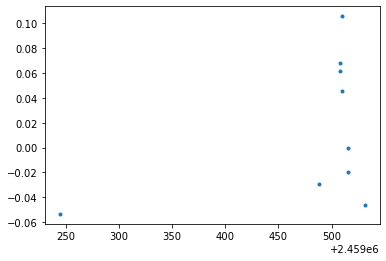

In [4]:
pl.plot(df['bjd'],df['rv'], '.')

In [5]:
T0 = 2459206.74743
P = 2.50079 #day
Ms = 0.261#solar mass
Mp = 68 #earth mass, tentative

a_rs = (0.023 * con.au/ (0.268 * con.R_sun)).value

b = 0.49
inc = np.arccos(b / a_rs)#rad

In [6]:
def rv_model_K(K, t0, p, tm):  
    rv = K* np.sin(2 * np.pi / p * (tm-t0))
    return rv
def rv_model_K_phase(K, ph):
    rv = K*np.sin(ph*np.pi*2)
    return rv

In [7]:
# 横軸phaseでplotするために

def phase(OBS_JD, T0, P):
    n = np.floor((OBS_JD-T0)/P)
    tr_before = T0 + n * P             #the JD of the last transit (phase=0) before the observation
    ph = (OBS_JD - tr_before)/P
    return ph

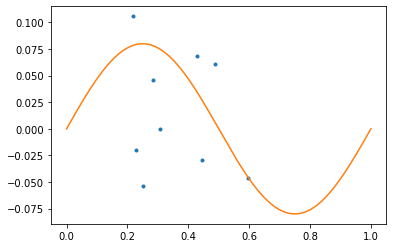

In [8]:
phase_obs = phase(df['bjd'], T0, P)
phase_pr = np.linspace(0,1,10000)

pl.plot(phase_obs, df['rv'], '.')
pl.plot(phase_pr, rv_model_K_phase(0.08, phase_pr), '-')

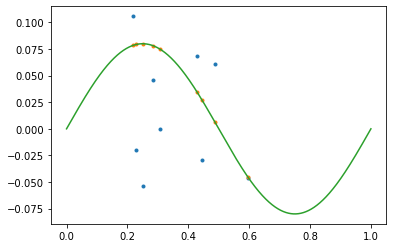

In [9]:
pl.plot(phase_obs, df['rv'], '.')
pl.plot(phase_obs, rv_model_K_phase(0.08, phase_obs), '.')
pl.plot(phase_pr, rv_model_K_phase(0.08, phase_pr), '-')

In [10]:
pd.DataFrame({'phase':phase_obs, 'rv_obs':df['rv'], 'rv_model':rv_model_K_phase(0.08, phase_obs)})

,phase,rv_obs,rv_model
0,0.250090,-0.053392,0.080000
1,0.445876,-0.029687,0.026684
2,0.427791,0.068336,0.035064
3,0.487738,0.061334,0.006157
4,0.217534,0.105841,0.078341
5,0.285627,0.045615,0.078004
6,0.229187,-0.019704,0.079317
7,0.308506,0.000000,0.074655
8,0.595197,-0.046459,-0.045049


In [11]:
def logprob(K):
    rv_o = df['rv']
    rv_e = df['rv_err']
    rv_m = rv_model_K_phase(K, phase_obs)
    
    return -0.5 * np.sum(((rv_o - rv_m)/rv_e)**2)

In [12]:
import emcee

K=[0.05]

dim = 1
nwalkers = 100
nsteps=1000
pos0 = [K + 1e-4 * np.random.randn(dim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, dim, logprob)
sampler.run_mcmc(pos0, nsteps, progress=True)

100%|██████████| 1000/1000 [00:58<00:00, 16.10it/s]


State([[ 0.02611394]
 [ 0.0118273 ]
 [ 0.0148424 ]
 [ 0.01944604]
 [ 0.01443824]
 [ 0.01138697]
 [ 0.02516232]
 [ 0.01476693]
 [ 0.01953983]
 [ 0.02782361]
 [ 0.03000146]
 [ 0.02569741]
 [ 0.00640531]
 [ 0.02148824]
 [ 0.01158473]
 [ 0.0221591 ]
 [ 0.02438978]
 [ 0.02420231]
 [ 0.02132529]
 [ 0.01631359]
 [ 0.01495863]
 [ 0.00392162]
 [ 0.02297775]
 [ 0.02340966]
 [ 0.02488705]
 [ 0.0105471 ]
 [ 0.01078886]
 [ 0.00870365]
 [ 0.01591749]
 [ 0.01888431]
 [ 0.02083293]
 [ 0.00632378]
 [ 0.02091117]
 [ 0.02090093]
 [ 0.01890507]
 [ 0.02819914]
 [ 0.01389372]
 [ 0.01247103]
 [ 0.01665161]
 [ 0.02968888]
 [ 0.01625795]
 [ 0.01637405]
 [ 0.01624574]
 [ 0.02525748]
 [ 0.02108802]
 [ 0.01763343]
 [ 0.00990587]
 [ 0.01052569]
 [ 0.00068022]
 [ 0.01221401]
 [ 0.00810034]
 [-0.00012883]
 [ 0.01995257]
 [ 0.02548968]
 [ 0.01441311]
 [ 0.01339582]
 [ 0.01725778]
 [ 0.01669437]
 [ 0.00450931]
 [ 0.01980082]
 [ 0.01349659]
 [ 0.01307104]
 [ 0.00954431]
 [ 0.01459486]
 [ 0.02482016]
 [ 0.00901841]
 [ 0

In [13]:
sampler.chain[:,:].shape

(100, 1000, 1)

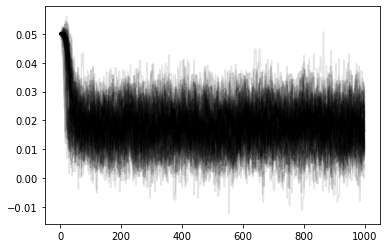

In [14]:
pl.plot(sampler.chain[:,:,0].T, color='k', alpha=0.1)

(array([4.000e+00, 1.000e+00, 1.000e+00, 6.000e+00, 2.300e+01, 2.300e+01,
        1.900e+01, 6.700e+01, 1.190e+02, 1.530e+02, 2.590e+02, 4.280e+02,
        7.130e+02, 1.028e+03, 1.353e+03, 1.875e+03, 2.539e+03, 2.886e+03,
        3.537e+03, 4.025e+03, 4.795e+03, 4.955e+03, 5.586e+03, 5.651e+03,
        5.756e+03, 5.553e+03, 5.125e+03, 4.732e+03, 4.210e+03, 3.610e+03,
        2.897e+03, 2.227e+03, 1.737e+03, 1.411e+03, 9.270e+02, 6.250e+02,
        4.220e+02, 2.840e+02, 2.030e+02, 1.090e+02, 5.400e+01, 3.200e+01,
        1.800e+01, 8.000e+00, 6.000e+00, 6.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([-0.0124442 , -0.01118147, -0.00991874, -0.00865601, -0.00739328,
        -0.00613055, -0.00486782, -0.00360509, -0.00234236, -0.00107963,
         0.0001831 ,  0.00144583,  0.00270856,  0.00397129,  0.00523402,
         0.00649676,  0.00775949,  0.00902222,  0.01028495,  0.01154768,
         0.01281041,  0.01407314,  0.01533587,  0.0165986 ,  0.01786133,
         0.

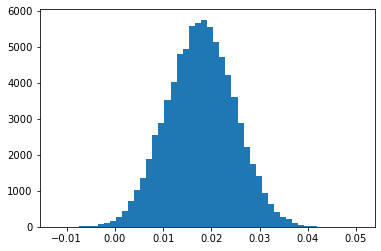

In [24]:
samples=sampler.chain[:,200:, :].reshape(-1)
df_chain= pd.DataFrame(samples)
pl.hist(samples, bins=50)

In [28]:
A,B,C,D,E=np.percentile(df_chain[0], [ 2.5, 16, 50, 84, 97.5], axis=0)
del1l =C-B   #1sigma
del1h=D-C
del2l=C-A   #2sigma
del2h=E-C 

best_K = C
best_K_err1=max(del1l,del1h)
best_K_err2=max(del2l,del2h)

print(best_K, best_K_err1, best_K_err2)

0.017852617328719303 0.007063806358682137 0.01364976245693221


収束判定まだしてないよ！

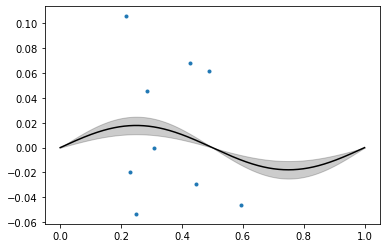

In [34]:
fig, ax = pl.subplots()

ax.plot(phase_obs, df['rv'], '.')

ax.plot(phase_pr, rv_model_K_phase(best_K, phase_pr), '-', color='k')

y1 = rv_model_K_phase(best_K+best_K_err1, phase_pr)
y2 = rv_model_K_phase(best_K-best_K_err1, phase_pr)

ax.fill_between(phase_pr, y1, y2, color='k', alpha=0.2)